In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
!ls ../../../data/out_metrics/*202412*lay_act*12_16*

../../../data/out_metrics/results_20241203_125550_lay_act_12_16.pkl
../../../data/out_metrics/results_20241204_084350_lay_act_12_16.pkl
../../../data/out_metrics/results_20241205_070611_lay_act_12_16.pkl


In [2]:
files = ['../../../data/out_metrics/results_20241203_032637_lay_act_0_4.pkl',
         '../../../data/out_metrics/results_20241205_005016_lay_act_1_4.pkl',
         '../../../data/out_metrics/results_20241203_202938_lay_act_4_8.pkl',
        '../../../data/out_metrics/results_20241204_221044_lay_act_7_8.pkl',
        '../../../data/out_metrics/results_20241204_093241_lay_act_8_12.pkl',
         '../../../data/out_metrics/results_20241205_070611_lay_act_12_16.pkl',
         '../../../data/out_metrics/results_20241205_055849_lay_act_16_20.pkl',
         '../../../data/out_metrics/results_20241205_111243_lay_act_20_22.pkl',
        ]

In [3]:
all_results = dict()
for file_name in files:
    with open(file_name, "rb") as file:
        results = dict(pickle.load(file))
    all_results = {**all_results, **results}
    
len(all_results)

{(50000,
  'default',
  1): [[9.962,
   13.082,
   61.112,
   81.656,
   91.472,
   93.596,
   93.726,
   93.852,
   93.83,
   93.844,
   93.848,
   93.834,
   93.846,
   93.874,
   93.84,
   93.838,
   93.848,
   93.83,
   93.822,
   93.872,
   93.84,
   93.86,
   93.844,
   93.862,
   93.858,
   93.842,
   93.846,
   93.86,
   93.822,
   93.874,
   93.884,
   93.854,
   93.872,
   93.86,
   93.86,
   93.87,
   93.876,
   93.856,
   93.812,
   93.87,
   93.894,
   93.868,
   93.84,
   93.848,
   93.854,
   93.91,
   93.806,
   93.842,
   93.808,
   93.856,
   93.81,
   93.862,
   93.824,
   93.822,
   93.852,
   93.826,
   93.874,
   93.816,
   93.824,
   93.856,
   93.854,
   93.894,
   93.87,
   93.862,
   93.884,
   93.84,
   93.88,
   93.804,
   93.828,
   93.898,
   93.906,
   93.85,
   93.842,
   93.862,
   93.796,
   93.852,
   93.904,
   93.804,
   93.826,
   93.89,
   93.908,
   93.914,
   93.832,
   93.84,
   93.866,
   93.832,
   93.888,
   93.832,
   93.884,
   93.88,
   9

In [31]:
# Flatten the data while preserving the structure from the tuple keys
flattened_data = {
    "activation_function": [],
    "num_layers": [],
    "n_rows": [],
    "iteration": [],
    "epochs": [],
    "values": []
}

# Iterate over each dataset size, activation function, and number of layers
for (n_rows, act_fn, n_layers), list_of_iterations in all_results.items():
    # For each iteration in the dataset size
    for i, iteration_list in enumerate(list_of_iterations):
        # Flatten the iteration list with epochs multiplied by 2 (0, 2, 4, ..., 18)
        for epoch, value in enumerate(iteration_list):
            cur_act_fn = act_fn
            if act_fn == 'default':
                cur_act_fn = "default"
            flattened_data["activation_function"].append(cur_act_fn)
            flattened_data["num_layers"].append(n_layers)
            flattened_data["n_rows"].append(n_rows)
            flattened_data["iteration"].append(i)
            flattened_data["epochs"].append(epoch * 2)
            flattened_data["values"].append(value)

# Convert to DataFrame for plotting
results_melted = pd.DataFrame(flattened_data)
pd.DataFrame(all_results).T

0  \
50000  default 1  [9.962, 13.082, 61.112, 81.656, 91.472, 93.596...   
               2  [9.938, 12.474, 18.27, 55.254, 75.056, 85.402,...   
       GELU    2  [9.938, 11.594, 16.15, 42.79, 71.882, 84.772, ...   
               4  [9.938, 9.938, 10.8, 11.906, 13.178, 15.118, 1...   
       RAF     1  [9.952, 11.812, 41.346, 61.09, 71.566, 81.354,...   
               2  [9.938, 10.926, 13.19, 18.448, 43.93, 59.632, ...   
               4  [9.938, 9.938, 10.53, 11.9, 13.26, 15.296, 16....   
       softmax 1  [10.388, 23.848, 57.234, 67.294, 77.012, 85.56...   
               2  [9.958, 11.444, 20.7, 54.882, 62.696, 70.02, 7...   
               4  [9.938, 10.678, 12.282, 16.012, 37.852, 53.888...   
100000 default 1  [9.936, 9.934, 10.439, 47.905, 54.335, 63.553,...   
               2  [9.934, 9.983, 10.963, 20.797, 51.352, 61.307,...   
               4  [9.934, 9.934, 9.934, 10.125, 11.46, 13.987, 1...   
       GELU    2  [9.934, 9.934, 10.247, 11.377, 18.896, 44.843,...   
               4  [9.934, 9.934, 10.987, 12.2, 13.915, 15.854, 1...   
       RAF     1  [9.934, 9.934, 9.94, 13.158, 46.144, 54.271, 6...   
               4  [9.934, 9.934, 9.934, 10.128, 11.722, 13.046, ...   

                                                                  1  \
50000  default 1  [10.174, 13.282, 61.752, 82.71, 92.372, 93.746...   
               2  [10.184, 13.3, 19.664, 59.2, 77.928, 87.232, 9...   
       GELU    2  [10.184, 11.946, 16.716, 41.944, 73.034, 85.84...   
               4  [10.184, 10.184, 10.88, 12.544, 15.132, 17.662...   
       RAF     1  [10.214, 11.506, 41.114, 61.552, 71.29, 81.362...   
               2  [10.184, 11.524, 14.172, 21.514, 49.892, 61.01...   
               4  [10.184, 10.184, 10.184, 11.41, 12.482, 13.642...   
       softmax 1  [10.49, 29.08, 58.354, 68.242, 78.716, 86.788,...   
               2  [10.242, 11.556, 24.054, 55.472, 62.546, 69.87...   
               4  [10.174, 10.962, 12.538, 15.768, 36.996, 53.76...   
100000 default 1  [10.068, 10.068, 9.765, 10.357, 45.5, 52.318, ...   
               2  [10.068, 10.322, 12.558, 35.309, 56.387, 65.84...   
               4  [10.068, 10.068, 10.068, 10.068, 10.068, 12.56...   
       GELU    2  [10.068, 10.07, 10.373, 12.718, 21.521, 46.442...   
               4  [10.068, 10.068, 10.068, 10.068, 10.068, 12.04...   
       RAF     1  [10.068, 10.068, 10.072, 13.301, 47.557, 56.04...   
               4  [10.068, 10.068, 10.068, 10.068, 10.068, 10.66...   

                                                                  2  \
50000  default 1  [10.062, 12.228, 56.956, 79.91, 91.352, 93.498...   
               2  [10.062, 13.528, 21.49, 60.536, 77.704, 86.966...   
       GELU    2  [10.062, 11.766, 17.188, 50.038, 73.992, 85.68...   
               4  [10.062, 10.062, 10.062, 10.09, 10.36, 12.186,...   
       RAF     1  [10.064, 11.092, 36.15, 59.694, 69.07, 79.224,...   
               2  [10.062, 11.71, 14.396, 22.75, 50.304, 61.786,...   
               4  [10.062, 10.062, 10.1, 10.924, 12.646, 14.63, ...   
       softmax 1  [10.138, 21.05, 56.57, 66.208, 76.114, 84.848,...   
               2  [10.152, 11.72, 28.966, 55.558, 62.334, 69.412...   
               4  [10.058, 10.836, 12.65, 15.556, 34.104, 53.924...   
100000 default 1  [10.028, 10.028, 10.084, 42.818, 51.441, 60.77...   
               2  [10.028, 10.028, 10.041, 10.586, 26.623, 50.15...   
               4  [10.028, 10.028, 10.028, 11.004, 12.211, 14.25...   
       GELU    2  [10.028, 10.028, 10.191, 11.351, 14.083, 19.02...   
               4  [10.028, 10.028, 10.028, 10.076, 12.349, 13.58...   
       RAF     1  [10.028, 10.028, 10.028, 10.083, 35.652, 52.48...   
               4  [10.028, 10.028, 10.028, 10.791, 11.788, 14.16...   

                                                                  3  \
50000  default 1  [9.28, 12.4, 61.222, 82.664, 92.128, 93.77, 93...   
               2  [9.91, 12.394, 18.52, 56.324, 76.454, 86.856, ...   
       GELU    2

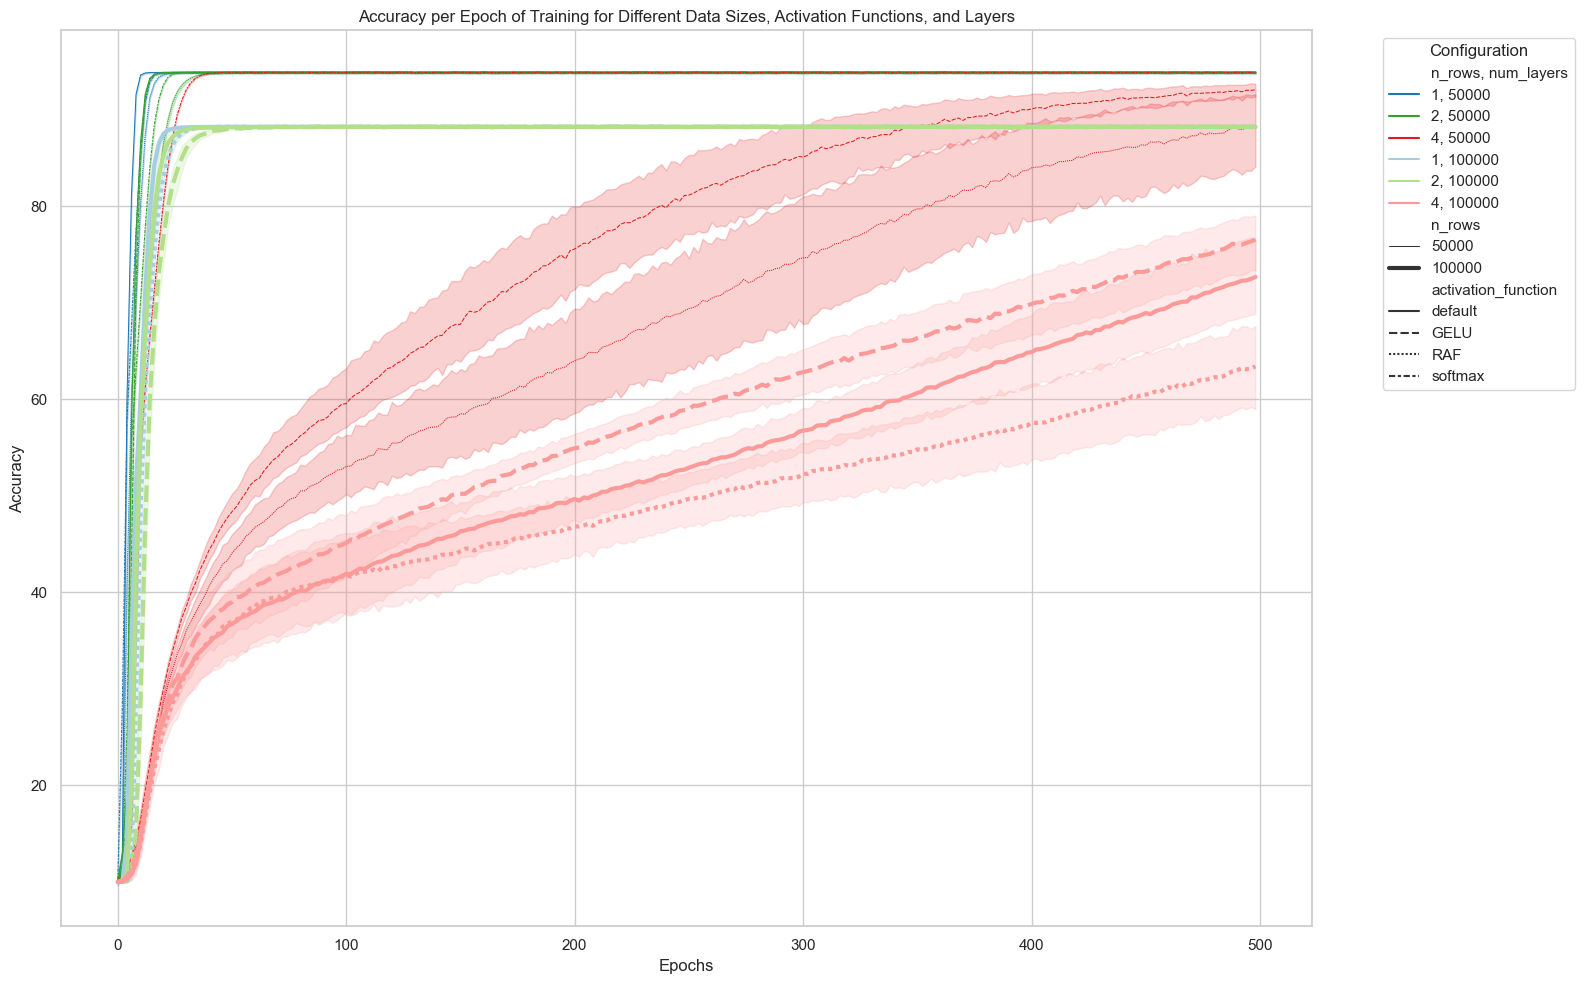

In [32]:
# Generate unique colors for each Num_Layers value
unique_layers = results_melted['num_layers'].unique()
layer_palette = sns.color_palette("Set2", len(unique_layers))
layer_color_map = {layer: color for layer, color in zip(unique_layers, layer_palette)}

results_melted['n_rows, num_layers'] = results_melted['num_layers'].astype(str) + ", " + results_melted['n_rows'].astype(str)  
unique_hues = sorted(results_melted['n_rows, num_layers'].unique())
layer_color_map = {hue: sns.color_palette("Paired")[i % 10] for i, hue in enumerate(unique_hues)}


# Plot with Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(16, 10))


sns.lineplot(
    data=results_melted,
    x="epochs",
    y="values",
    hue="n_rows, num_layers",  # Combined hue for Num_Layers and N_rows
    style="activation_function",
    size="n_rows",
    palette=layer_color_map,  # Ensure this supports the combined categories
    linewidth=1,
)

# Add labels and legend
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch of Training for Different Data Sizes, Activation Functions, and Layers")
plt.legend(title="Configuration", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

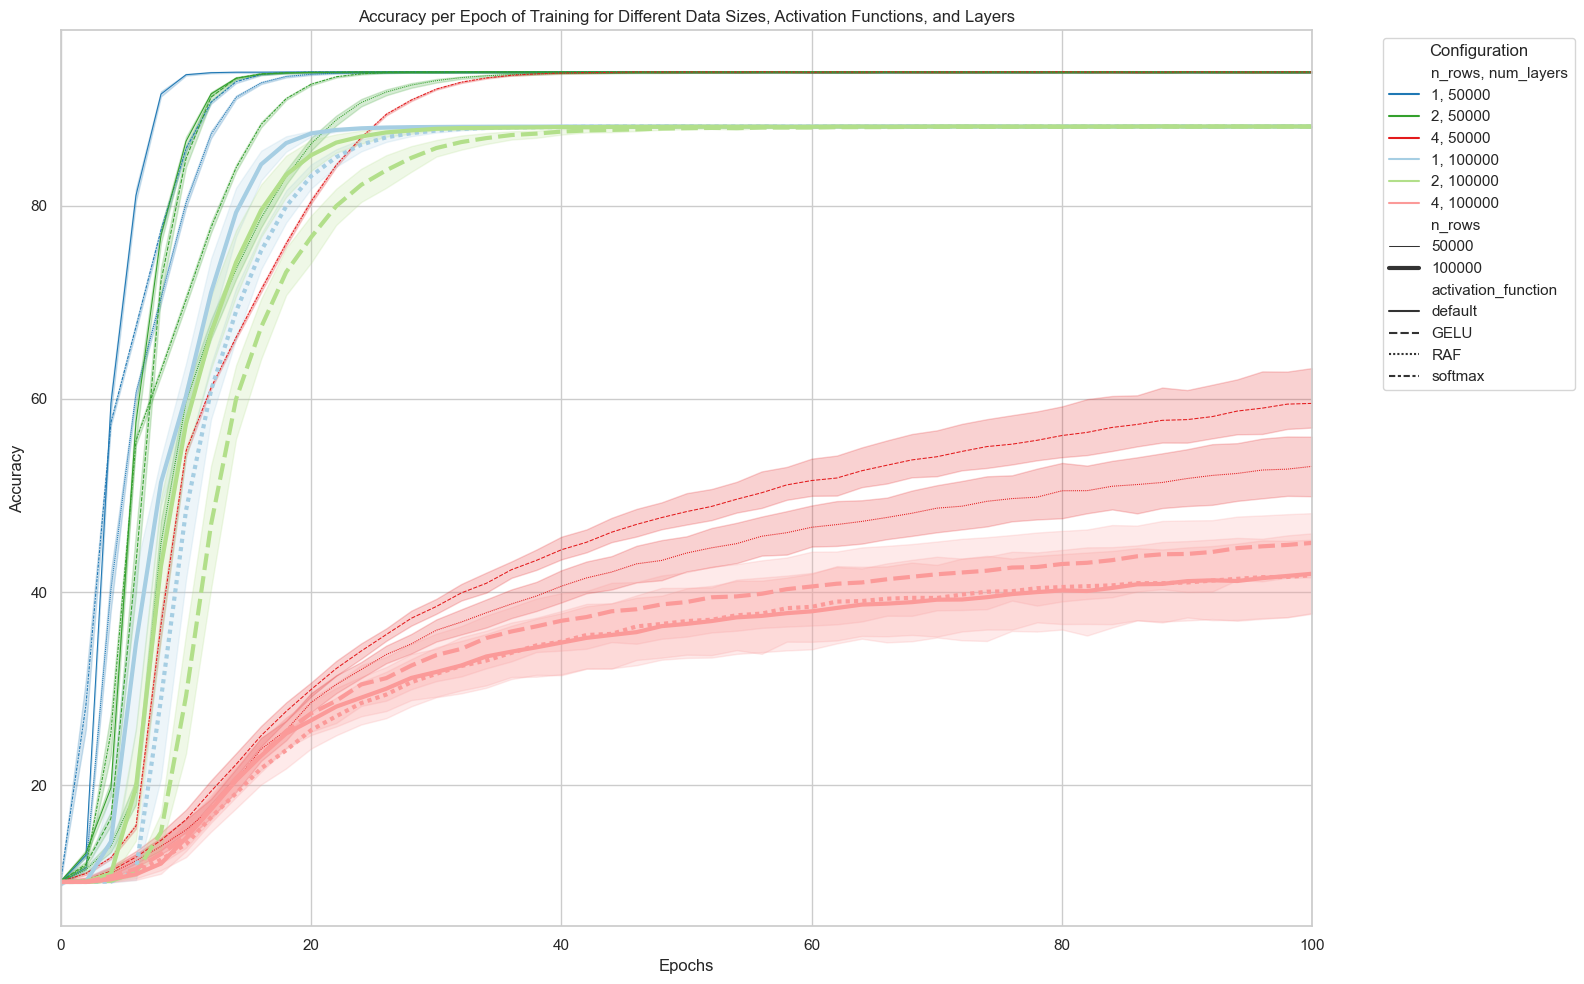

In [36]:
cur_cutoff = 100
cur_results_melted = results_melted[results_melted.epochs<=cur_cutoff]

# Plot with Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(16, 10))

sns.lineplot(
    data=cur_results_melted ,
    x="epochs",
    y="values",
    hue="n_rows, num_layers",  # Combined hue for Num_Layers and N_rows
    style="activation_function",
    size="n_rows",
    palette=layer_color_map,  # Ensure this supports the combined categories
    linewidth=1,
)

plt.xlim(0, cur_cutoff)

# Add labels and legend
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch of Training for Different Data Sizes, Activation Functions, and Layers")
plt.legend(title="Configuration", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

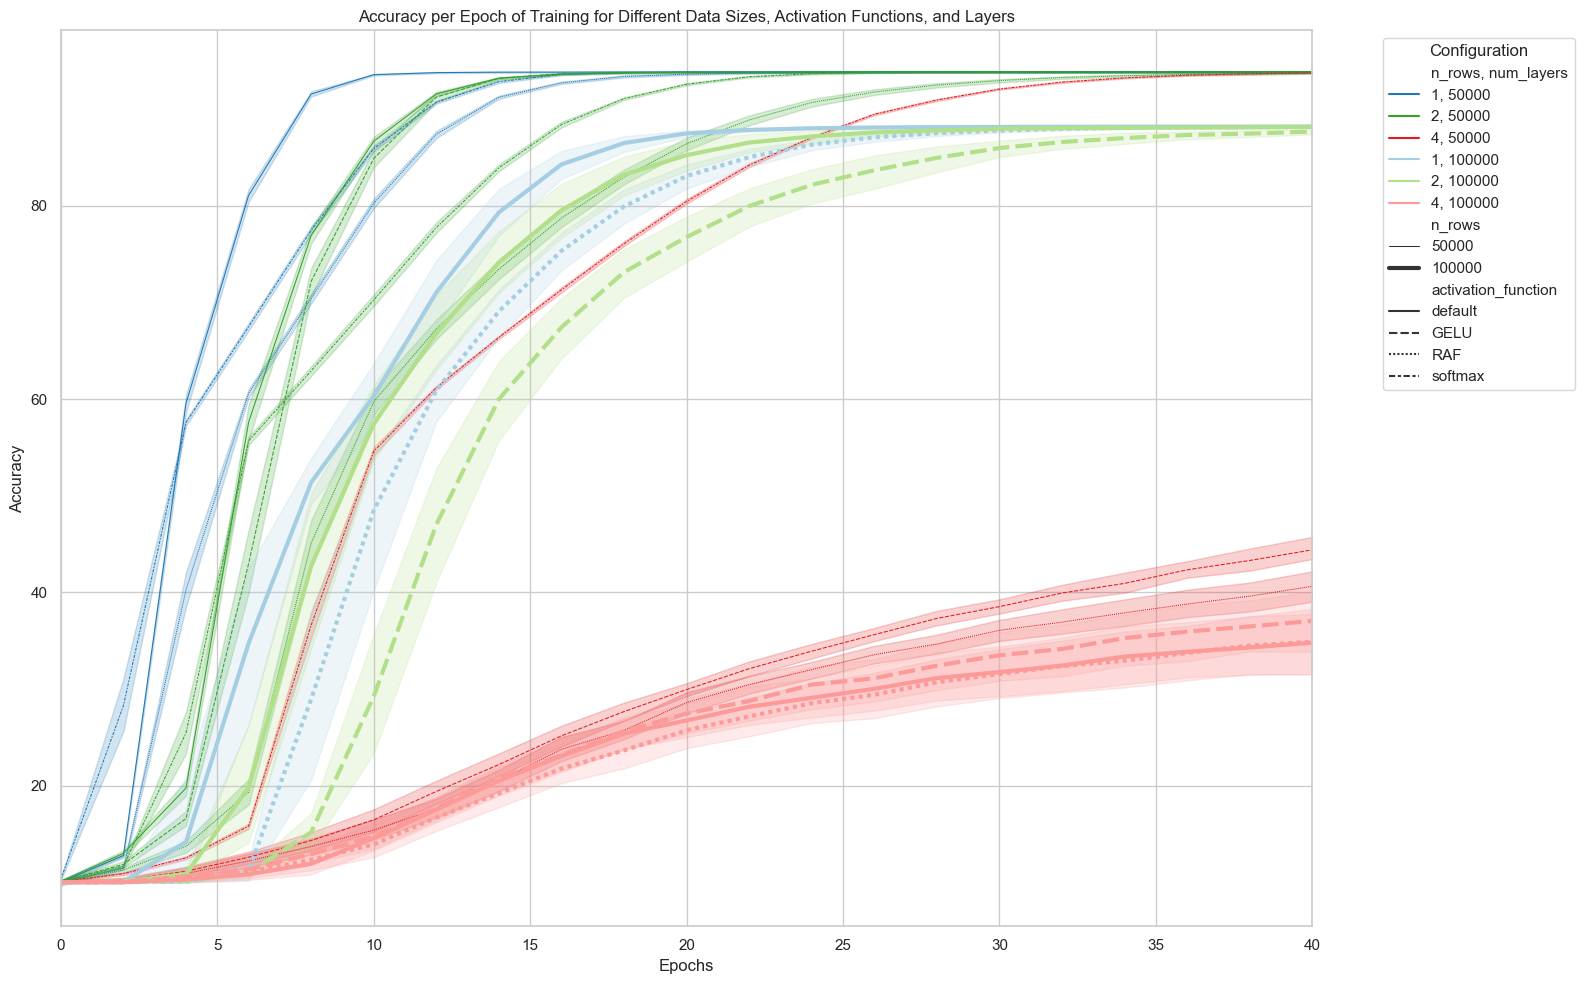

In [40]:
cur_cutoff = 40
cur_results_melted = results_melted[results_melted.epochs<=cur_cutoff]

# Plot with Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(16, 10))

sns.lineplot(
    data=cur_results_melted ,
    x="epochs",
    y="values",
    hue="n_rows, num_layers",  # Combined hue for Num_Layers and N_rows
    style="activation_function",
    size="n_rows",
    palette=layer_color_map,  # Ensure this supports the combined categories
    linewidth=1,
)

plt.xlim(0, cur_cutoff)

# Add labels and legend
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch of Training for Different Data Sizes, Activation Functions, and Layers")
plt.legend(title="Configuration", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()